In [1]:
import openai
import wandb
from pathlib import Path
import pandas as pd
import numpy as np
import json
from tqdm import tqdm


In [2]:
!openai wandb sync


No new successful fine-tunes were found
🎉 wandb sync completed successfully


wandb: Currently logged in as: ghosh-11. Use `wandb login --relogin` to force relogin


In [ ]:
from datasets import list_datasets
list_datasets()

In [4]:
from datasets import load_dataset

dataset = load_dataset("amazon_polarity",  split="test")
dataset

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Dataset amazon_polarity downloaded and prepared to C:/Users/debon/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc. Subsequent calls will reuse this data.


Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 400000
})

In [16]:
#dataset = dataset.remove_columns(['prompt', 'completion'])

In [18]:
def mapToPromt(x):
    x['prompt'] = x['content'] + '\n\n###\n\n'
    x['completion'] = ' ' + str(x['label'])
    return x

In [19]:
dataset = dataset.map(mapToPromt)

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [22]:
import pandas as pd
import os

ds_split_1 = dataset.train_test_split(test_size=0.2, shuffle=True)
ds_split_2 = ds_split_1['test'].train_test_split(test_size=0.5, shuffle=True)
ds_list = [ds_split_1['train'],ds_split_2['train'],ds_split_2['test']]
file_types = ['trn', 'dev', 'tst']
for i,f in enumerate(file_types):
    #src_data_df = pd.read_csv(f'../data/amazon_polarity.{f}.csv').sample(frac=0.05)
    result_df = pd.DataFrame()

    result_df['prompt'] = ds_list[i]['prompt']
    result_df['completion'] = ds_list[i]['completion']

    result_df.to_json(
        f'../data/amazon_polarity.{f}.tiny.promted_prepared.jsonl', orient='records', lines=True)
    print(
        f'openai tools fine_tunes.prepare_data -f data/amazon_polarity.{f}.tiny.promted_prepared.jsonl')

openai tools fine_tunes.prepare_data -f data/amazon_polarity.trn.tiny.promted_prepared.jsonl
openai tools fine_tunes.prepare_data -f data/amazon_polarity.dev.tiny.promted_prepared.jsonl
openai tools fine_tunes.prepare_data -f data/amazon_polarity.tst.tiny.promted_prepared.jsonl


In [4]:
!openai tools fine_tunes.prepare_data - f ../data/SBIC.v2.agg.trn.promted.csv


^C


In [23]:
!openai api fine_tunes.create -t "data/amazon_polarity.trn.tiny.promted_prepared.jsonl" - v "data/amazon_polarity.dev.tiny.promted_prepared.jsonl" --compute_classification_metrics --classification_positive_class " 1" -m davinci --n_epochs 1 --learning_rate_multiplier 0.05


usage: openai api fine_tunes.create [-h] -t TRAINING_FILE [-v VALIDATION_FILE]
                                    [--no_check_if_files_exist] [-m MODEL]
                                    [--suffix SUFFIX] [--no_follow]
                                    [--n_epochs N_EPOCHS]
                                    [--batch_size BATCH_SIZE]
                                    [--learning_rate_multiplier LEARNING_RATE_MULTIPLIER]
                                    [--prompt_loss_weight PROMPT_LOSS_WEIGHT]
                                    [--compute_classification_metrics]
                                    [--classification_n_classes CLASSIFICATION_N_CLASSES]
                                    [--classification_positive_class CLASSIFICATION_POSITIVE_CLASS]
                                    [--classification_betas CLASSIFICATION_BETAS [CLASSIFICATION_BETAS ...]]
openai api fine_tunes.create: error: the following arguments are required: -t/--training_file


In [24]:
!curl https: // api.openai.com/v1/fine-tunes/ft-u3oC6MarWll2btewysd1wTI8 - H "Authorization: Bearer $OPENAI_API_KEY" > ../results/fine-tuned-davinchi.json


curl: option -: is unknown
curl: try 'curl --help' for more information


In [25]:
!openai api fine_tunes.results - i ft-u3oC6MarWll2btewysd1wTI8 > result.csv


usage: openai api fine_tunes.results [-h] -i ID
openai api fine_tunes.results: error: the following arguments are required: -i/--id


In [26]:
results = pd.read_csv('../results/results_davinchi.csv')
results[results['classification/accuracy'].notnull()].tail(1)


,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
3542,3543,312190,7086,0.021387,1.0,1.0,NaN,NaN,NaN,0.811159,0.809917,0.823529,0.859539,0.856152,0.816667


<AxesSubplot:>

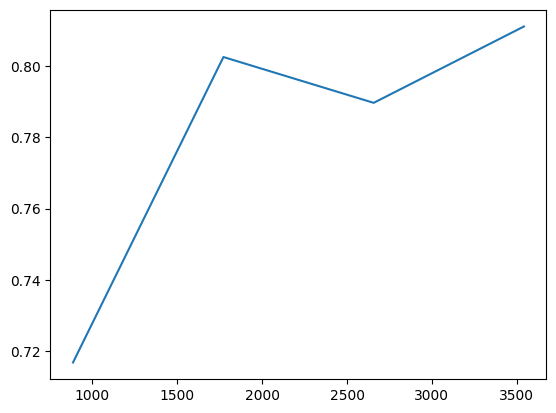

In [27]:
results[results['classification/accuracy'].notnull()
        ]['classification/accuracy'].plot()

<AxesSubplot:>

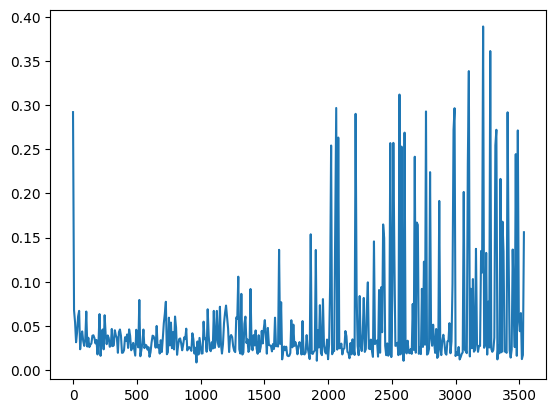

In [11]:
results[results['validation_loss'].notnull()]['validation_loss'].plot()


Using the model

In [2]:
test = pd.read_json(
    '../data/SBIC.v2.agg.tst.tiny.promted_prepared.jsonl', orient='records', lines=True)
test.head()

,prompt,completion
0,1 horrible cunt that Ross Barkley. 2 bad tackl...,1
1,Parents:\n\nIf YOU do not teach your children ...,1
2,"The kikes probably put the Leftist up to it , ...",1
3,"""Just when you think the Swans are dead and bu...",0
4,It is people like James O'Keefe and Project Ve...,0


In [19]:

import openai
ft_model = 'davinci:ft-personal-2023-05-07-12-34-28'


def inferGPT3FineTuned(input):
    res = openai.Completion.create(
        model=ft_model, prompt=input, max_tokens=1, temperature=0)
    return int(res['choices'][0]['text'].strip())


inferGPT3FineTuned(test['prompt'][2])

1

In [4]:
print(test['prompt'][2])
res = openai.Completion.create(
    model=ft_model, prompt=test['prompt'][2], max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

The kikes probably put the Leftist up to it , to make it seem like they do n't have total control of everyone .

###




<OpenAIObject at 0x1abe31e27f0> JSON: {
  " 0": -11.771873,
  " 1": -3.988961e-05
}

In [40]:
from sklearn import metrics
import seaborn as sns
# sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})
import pandas as pd
import matplotlib.pyplot as plt
import time


def confusionMatrixAndAccuracyReport(Y_test, Y_pred, classes, title=''):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    f1_score = metrics.f1_score(Y_test, Y_pred, average='weighted')

    plt.figure(figsize=(10, 10))
    plt.title(
        f'{title} : Accuracy : {overallAccuracy*100:3.2f}% | F1 Score : {f1_score*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',
                fmt='g', xticklabels=classes, yticklabels=classes)

    # plt.show()
    plt.savefig(
        f'../results/confusion_mat_{title}.png', bbox_inches='tight')
    print(f'Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'F1 Score: {f1_score*100:3.3f}%')
    classwiseAccuracy_df = pd.DataFrame(
        data=[classwiseAccuracy], columns=classes)
    print(
        f'\nClasswise Accuracy Score: \n{classwiseAccuracy_df.to_markdown(index=False)}')
    print('\nConfusion Matrix:')
    print(cm.to_markdown())
    # wandb.log({"accuracy_score": overallAccuracy, "f1_score": f1_score, })

In [13]:
test


,prompt,completion
0,1 horrible cunt that Ross Barkley. 2 bad tackl...,1
1,Parents:\n\nIf YOU do not teach your children ...,1
2,"The kikes probably put the Leftist up to it , ...",1
3,"""Just when you think the Swans are dead and bu...",0
4,It is people like James O'Keefe and Project Ve...,0
...,...,...
230,Not All Straight Men - I am frustrated. Unlike...,0
231,My dad was salty he failed no nut November My ...,0
232,There is no doubt in my mind that the #LegacyM...,1
233,F3701: Japanese Wooden Lacquer ware Drawer CHE...,0


In [ ]:

predicted = []
for row in test.values:
    predicted.append(inferGPT3FineTuned(row[0]))

In [38]:
print(metrics.classification_report(test['completion'].values, predicted))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       104
           1       0.92      0.89      0.90       131

    accuracy                           0.89       235
   macro avg       0.89      0.89      0.89       235
weighted avg       0.89      0.89      0.89       235



Accuracy: 89.362%
F1 Score: 89.383%

Classwise Accuracy Score: 
|     Hate |   Non-Hate |
|---------:|-----------:|
| 0.903846 |   0.885496 |

Confusion Matrix:
| True Label   |   Hate |   Non-Hate |
|:-------------|-------:|-----------:|
| Hate         |     94 |         10 |
| Non-Hate     |     15 |        116 |


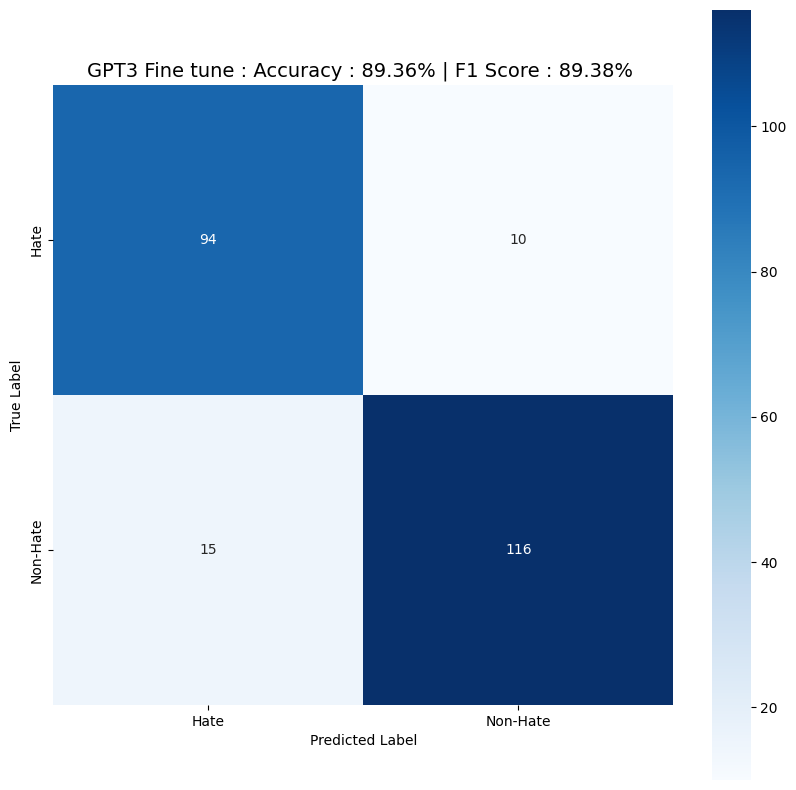

In [44]:

confusionMatrixAndAccuracyReport(test['completion'].values, predicted, ['Hate','Non-Hate'], title='GPT3 Fine tune')